In [ ]:
# pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error,mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_excel("Dataset.xlsx", skiprows=list(range(0,10)), index_col=0, parse_dates=True)
data

,GOLDAMGBD228NLBM
observation_date,
1968-04-01,38.00
1968-04-02,37.60
1968-04-03,37.70
1968-04-04,36.70
1968-04-05,37.20
...,...
2021-07-15,1832.00
2021-07-16,1822.00
2021-07-19,1803.25


In [ ]:
start_date = data.index[0]
end_date = data.index[-1]
dates = pd.date_range(start_date, end_date)
missing = []
nan_data = []

for date in dates:
    if date not in data.index:
        missing.append(date)
        nan_data.append(np.nan)
        
df = pd.DataFrame({"GOLDAMGBD228NLBM": nan_data}, index= missing)

df

,GOLDAMGBD228NLBM
1968-04-06,NaN
1968-04-07,NaN
1968-04-13,NaN
1968-04-14,NaN
1968-04-20,NaN
...,...
2021-07-04,NaN
2021-07-10,NaN
2021-07-11,NaN
2021-07-17,NaN


In [ ]:
total_df = pd.concat([data, df])
total_df.sort_index(inplace= True)
total_df

,GOLDAMGBD228NLBM
1968-04-01,38.00
1968-04-02,37.60
1968-04-03,37.70
1968-04-04,36.70
1968-04-05,37.20
...,...
2021-07-17,NaN
2021-07-18,NaN
2021-07-19,1803.25
2021-07-20,1815.30


In [ ]:
total_df.isnull().sum()

GOLDAMGBD228NLBM    5993
dtype: int64

In [ ]:
df = total_df.interpolate(method ='linear', limit_direction ='forward', limit = 100)
df.isnull().sum()

GOLDAMGBD228NLBM    0
dtype: int64

In [ ]:
df.rename(columns={"GOLDAMGBD228NLBM": "gold"}, inplace=True)
df

,gold
1968-04-01,38.00
1968-04-02,37.60
1968-04-03,37.70
1968-04-04,36.70
1968-04-05,37.20
...,...
2021-07-17,1815.75
2021-07-18,1809.50
2021-07-19,1803.25
2021-07-20,1815.30


In [ ]:
df.index.names = ['Date']

In [ ]:
train, validation = df.iloc[:int(df.shape[0]*0.80)],df.iloc[int(df.shape[0]*0.80):]
print(f"Dataset: {len(dataset)}, Validation: {len(validation)}")

Dataset: 15576, Validation: 3894


In [ ]:
model_arima= auto_arima(train["gold"],trace=True,
              error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
              start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2,
              max_order=5, seasonal=True,
              m=7,
              stationary=False, information_criterion='aic',
              suppress_warnings=True,stepwise=False,
              random=True)


 ARIMA(2,2,0)(1,0,0)[7]             : AIC=97568.452, Time=1.95 sec
 ARIMA(2,2,0)(0,0,2)[7]             : AIC=97568.340, Time=3.70 sec
 ARIMA(1,2,2)(1,0,1)[7]             : AIC=inf, Time=13.88 sec
 ARIMA(2,2,0)(0,0,1)[7]             : AIC=97568.722, Time=1.70 sec
 ARIMA(2,2,1)(0,0,2)[7]             : AIC=inf, Time=19.44 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=inf, Time=9.88 sec
 ARIMA(3,2,0)(2,0,0)[7]             : AIC=96795.465, Time=5.53 sec
 ARIMA(2,2,0)(1,0,1)[7]             : AIC=97565.326, Time=5.10 sec
 ARIMA(1,2,2)(0,0,0)[7]             : AIC=inf, Time=2.58 sec
 ARIMA(1,2,1)(2,0,0)[7]             : AIC=inf, Time=13.38 sec

Best model:  ARIMA(3,2,0)(2,0,0)[7]          
Total fit time: 77.256 seconds


In [ ]:
model_arima.fit(train["gold"])

ARIMA(maxiter=50, method='lbfgs', order=(3, 2, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 0, 7),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
prediction_arima = model_arima.predict(len(validation))
prediction_arima

array([1357.68046404, 1358.14211413, 1357.32807428, ...,  325.41935418,
        325.15420877,  324.88906336])

In [ ]:
def bold_text(txt):
  return f"\033[1m{txt}\033[0m"

In [ ]:
def eval_model(validation_data, model):
  prediction_arima = model.predict(len(validation_data))
  
  y_pred = validation_data.copy()

  y_pred["ARIMA Model Prediction"] = prediction_arima
  mse_arima = mean_squared_error(y_pred["gold"],y_pred["ARIMA Model Prediction"])
  rmse_arima = np.sqrt(mean_squared_error(y_pred["gold"],y_pred["ARIMA Model Prediction"]))

  print(f'''{bold_text("Model")}
Order : {model_arima.order}
Seasonal order: {model.seasonal_order}
AIC: {model.aic()}
MSE: {mse_arima}
RMSE: {rmse_arima}
''')

In [ ]:
eval_model(validation, model_arima)

Model
Order : (3, 2, 0)
Seasonal order: (2, 0, 0, 7)
AIC: 96795.46526486657
MSE: 493318.9733269995
RMSE: 702.3666943463361



In [ ]:
# Same model using statsmodels.tsa.arima.model.ARIMA object

final_model = ARIMA(train,order=model_arima.order,seasonal_order=model_arima.seasonal_order).fit()

In [ ]:
forecast = final_model.predict(len(df),len(df)+365,typ='levels').rename('ARIMA forecast')

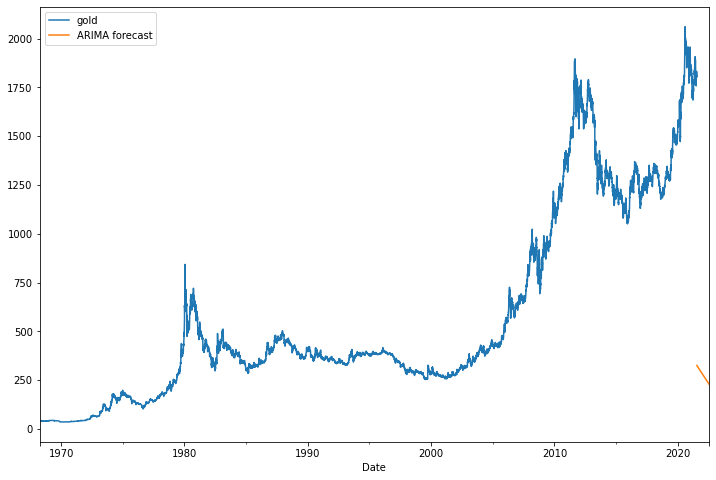

In [ ]:
df['gold'].plot(figsize=(12,8),legend=True)
forecast.plot(legend=True);

###### Observation: The ARIMA model is not giving great predictions on this dataset as the RMSE is 702 which is high in this case